# K-Nearest Neighbor(KNN) Tutorial

In this tutorial, we implement K-Nearest Neighbor (KNN) with Python. We use this algorithm to predict a tumour as malignant or benign.The variable we are going to be predicting can have one of the 2 values: 0 or 1. A complete description of the database used can be consulted [here](https://github.com/MihaiTudor26/Logistic_Regression_Tutorial/blob/master/Logistic_Regression_Tutorial.ipynb) .

✏️**Importing the required libraries for KNN.**

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
init_notebook_mode(connected = True)
cmap1 = "gist_gray"
import warnings 
warnings.filterwarnings('ignore')

✏️**Loading the data into the dataframe.**

In [52]:
df= pd.read_csv('breast_cancer.csv') #read the dataset

- **Dataset Information.**

In [53]:
print('The dataset contains {} row and {} columns.'.format(df.shape[0],df.shape[1]))
print('The size of dataset (rows x columns): ',df.size)

The dataset contains 683 row and 10 columns.
The size of dataset (rows x columns):  6830


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Clump Thickness              683 non-null    int64
 1   Uniformity of Cell Size      683 non-null    int64
 2   Uniformity of Cell Shape     683 non-null    int64
 3   Marginal Adhesion            683 non-null    int64
 4   Single Epithelial Cell Size  683 non-null    int64
 5   Bare Nuclei                  683 non-null    int64
 6   Bland Chromatin              683 non-null    int64
 7   Normal Nucleoli              683 non-null    int64
 8   Mitoses                      683 non-null    int64
 9   Class                        683 non-null    int64
dtypes: int64(10)
memory usage: 53.5 KB


We notice that all the variables are numerical.

✏️**Data Processing.**

- **Dropping the duplicate rows.**

In [55]:
duplicate_rows = df.duplicated().sum()
print("Number of duplicated rows: ", duplicate_rows)
df = df.drop_duplicates()

Number of duplicated rows:  234


In [56]:
print('The dataset contains {} row and {} columns.'.format(df.shape[0],df.shape[1]))

The dataset contains 449 row and 10 columns.


We will replace the value 2 with 0 and the value 4 with 1 in the class column. The value 1 will indicate malignant cancer and 0 will indicate benign cancer.

In [57]:
df=df.replace({'Class':{4:1, 2:0}})
df.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


- **A summary of the statistics relating to the numerical variables.**

In [58]:
round(df.describe(),2)

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,449.00,449.00,449.00,449.00,449.00,449.00,449.00,449.00,449.00,449.00
mean,5.38,4.22,4.27,3.75,3.88,4.81,4.20,3.83,1.91,0.53
std,2.87,3.25,3.14,3.16,2.46,3.88,2.65,3.39,2.07,0.50
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00
25%,3.00,1.00,1.00,1.00,2.00,1.00,2.00,1.00,1.00,0.00
50%,5.00,3.00,3.00,3.00,3.00,3.00,3.00,2.00,1.00,1.00
75%,8.00,7.00,7.00,6.00,5.00,10.00,7.00,7.00,2.00,1.00
max,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,1.00


- **Detect Outliers in numerical variables.**

In [59]:
def num_var_summary(dataframe,num_var):
    fig = make_subplots(rows = 1, cols = 2,
                       subplot_titles = ("Quantiles", "Distribution"))
    
    fig.add_trace(go.Box(y = dataframe[num_var],
                         name = str(num_var),
                         showlegend = False,
                         marker_color = "#A6D0DD"), 
                         row = 1, col = 1)
    
    fig.add_trace(go.Histogram(x = dataframe[num_var],
                               name = str(num_var),
                               showlegend = False,
                               xbins = dict(start = dataframe[num_var].min(),
                                            end = dataframe[num_var].max()),
                               marker=dict(color='rgb(12, 12, 140)',
                                           line = dict(color = '#DBE6EC',
                                                       width = 1))),
                  row = 1, col = 2)
    
    iplot(fig)

In [60]:
for var in df:
    num_var_summary(df,var)

We remove outliers by IQR Method.

In [61]:
df_update = df.copy()
Q1 = df_update.quantile(0.25)
Q3 = df_update.quantile(0.75)
IQR = Q3 - Q1
df_update = df_update[~((df_update < (Q1 - 1.5 * IQR)) | (df_update > (Q3 + 1.5 * IQR))).any(axis=1)]
df_update.shape

(379, 10)

In [62]:
for var in df_update:
    num_var_summary(df_update,var)

- **Define dependent and independent variables.**

In [63]:
y= df_update['Class'] #target variable
x= df_update.drop(['Class'], axis=1)#feature vector

- **Scale the data.**

In [64]:
x_scaled = preprocessing.scale(x)
x_scaled = pd.DataFrame(x_scaled, columns=x.columns) 

- **Split data into separate training and test set.**

In [65]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled,y, test_size= 0.2)

✏️**Fit the KNN model.**

In [66]:
knn = KNeighborsClassifier()

- **Perform Hyperparameter Tuning.**

In [67]:
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [68]:
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)

In [69]:
gs_fit = gs.fit(x_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [70]:
print("The best score: ",gs_fit.best_score_)

The best score:  0.9537953795379538


In [71]:
print("The best parameters: ",gs_fit.best_params_)

The best parameters:  {'metric': 'minkowski', 'n_neighbors': 13, 'weights': 'uniform'}


- **Use the best hyperparameters.**

In [72]:
knn = KNeighborsClassifier(n_neighbors = 13, weights = 'uniform',algorithm = 'brute',metric = 'minkowski')
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='brute', n_neighbors=13)

**✏️Evaluate the model using a confusion matrix.**

In [73]:
y_pred_train = knn.predict(x_train)
y_pred_test = knn.predict(x_test)

In [74]:
print('Training set accuracy: ', metrics.accuracy_score(y_train, y_pred_train))
print('Test set accuracy: ',metrics.accuracy_score(y_test, y_pred_test))

Training set accuracy:  0.9471947194719472
Test set accuracy:  0.9210526315789473


- **Create a confusion matrix.**

In [75]:
ConfusionMatrix=confusion_matrix(y_test, y_pred_test)
print(ConfusionMatrix)
print('\nTrue Positives(TP) = ', ConfusionMatrix[0,0])
print('\nTrue Negatives(TN) = ', ConfusionMatrix[1,1])
print('\nFalse Positives(FP) = ', ConfusionMatrix[0,1])
print('\nFalse Negatives(FN) = ', ConfusionMatrix[1,0])

[[40  3]
 [ 3 30]]

True Positives(TP) =  40

True Negatives(TN) =  30

False Positives(FP) =  3

False Negatives(FN) =  3


- **Display the visualization of the Confusion Matrix.**

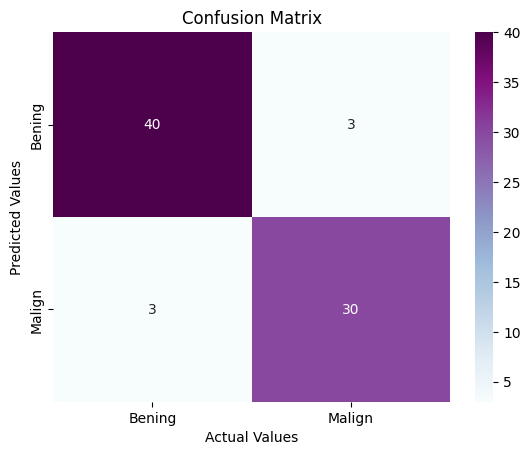

In [76]:
ax = sns.heatmap(ConfusionMatrix, annot=True, cmap='BuPu')
ax.set_title('Confusion Matrix');
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values');
ax.xaxis.set_ticklabels(['Bening','Malign'])
ax.yaxis.set_ticklabels(['Bening','Malign'])
plt.show()

- **Classification report.**

In [77]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        43
           1       0.91      0.91      0.91        33

    accuracy                           0.92        76
   macro avg       0.92      0.92      0.92        76
weighted avg       0.92      0.92      0.92        76



- **Classification error.**

In [78]:
TP = ConfusionMatrix[0,0]
TN = ConfusionMatrix[1,1]
FP = ConfusionMatrix[0,1]
FN = ConfusionMatrix[1,0]
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('Classification error : {0:0.4f}'.format(classification_error))

Classification error : 0.0789
